In [1]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'#path where you installed it

In [2]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
import sklearn
import torch
import seaborn as sns

from graphviz import Digraph
from IPython.display import Image
from utils import make_meshgrid
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from plotly.offline import plot

plt.rc("font", size=15)

pylab.rcParams['figure.figsize'] = 5, 5

plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(10815657)
mock_data=[]
centers=np.array([[0,0],[0,1],[1,0],[1,1]])
for v in range(4):
    for i in range(100):
        mock_data.append(np.random.randn(2)*0.1+centers[v])

# Deep learning : representation then task

## Linearly separable data

In [4]:
dico_color={0:'blue',1:'red'}
dico_separable={i:0 if int(i/100)<2 else 1 for i in range(len(mock_data))}

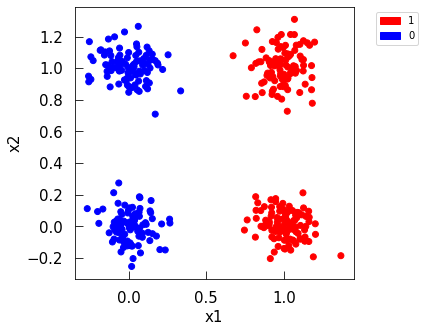

In [5]:
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')
list_patches=[red_patch,blue_patch]
plt.scatter([p[0] for p in mock_data],
            [p[1] for p in mock_data],
            c=[dico_color[dico_separable[i]] for i in range(len(mock_data))])
plt.legend(handles=list_patches,fontsize=10,bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [6]:
X_separable_df=pd.DataFrame(np.array(mock_data),columns=['x1','x2'])
X_separable_df['class']=[dico_separable[i] for i in range(len(mock_data))]


## Basic logistic regression

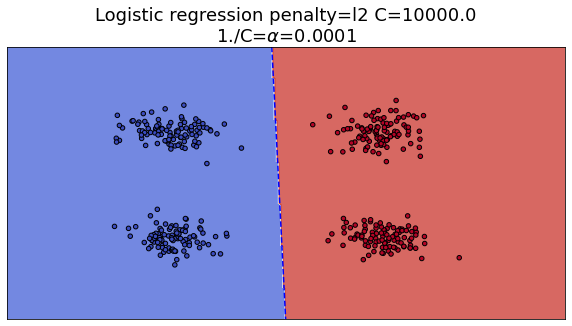

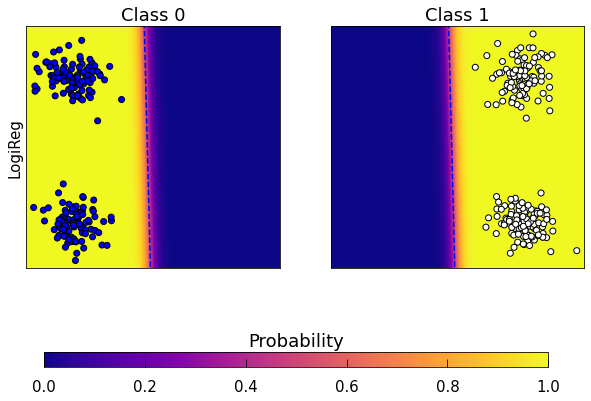

In [7]:
from utils2 import countour_lr2
alpha = 1/10000
countour_lr2('l2',np.array(X_separable_df[['x1','x2']]),X_separable_df['class'], 1 / alpha ,'ovr')

## Non linearly separable data : the infamous Xor problem

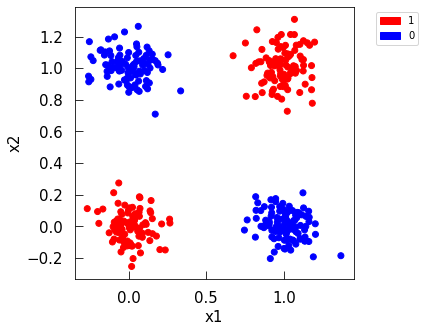

In [8]:
dico_not_separable={i:1 if int(i/100)==0 or int(i/100)==3 else 0 for i in range(len(mock_data))}
plt.scatter([p[0] for p in mock_data],
            [p[1] for p in mock_data],
           c=[dico_color[dico_not_separable[i]] for i in range(len(mock_data))])
plt.legend(handles=list_patches,fontsize=10,bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [9]:
X_not_separable_df=pd.DataFrame(np.array(mock_data),columns=['x1','x2'])
X_not_separable_df['class']=[dico_not_separable[i] for i in range(len(mock_data))]

from sklearn.utils import shuffle

X_not_separable_df = shuffle(X_not_separable_df,random_state=42)
X_not_separable_df.reset_index(inplace=True)
X_not_separable_df.head()

,index,x1,x2,class
0,209,0.903817,0.002759,0
1,280,1.075973,0.070959,0
2,33,0.010399,-0.022057,1
3,210,0.946742,0.156762,0
4,93,-0.062423,-0.040342,1


## Basic logistic regression fails

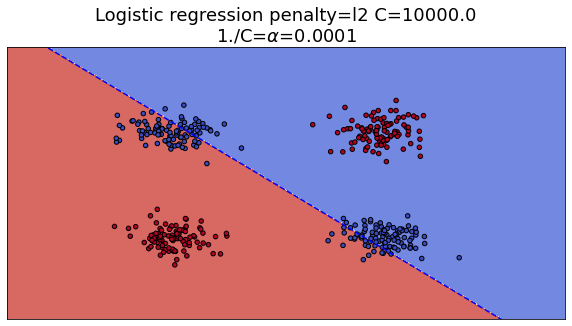

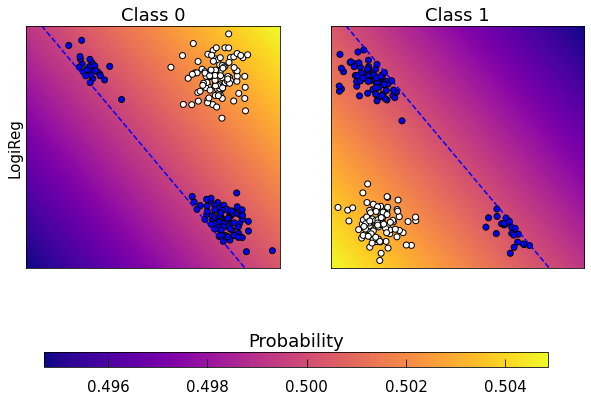

In [10]:
from utils2 import countour_lr2
alpha = 1/10000
countour_lr2('l2',np.array(X_not_separable_df[['x1','x2']]),X_not_separable_df['class'], 1 / alpha ,'ovr')

## But non linear kernel SVM does the trick

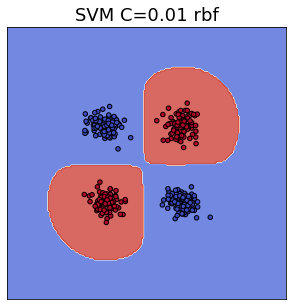

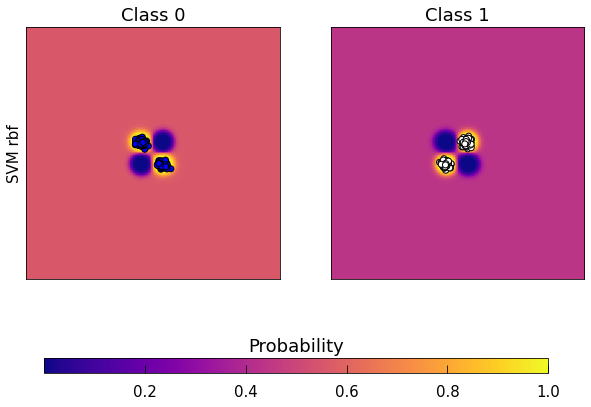

In [11]:
from utils2 import countour_SVM2
countour_SVM2(np.array(X_not_separable_df[['x1','x2']]),
             np.array(X_not_separable_df['class']),0.01,'rbf',2,10,'ovr')

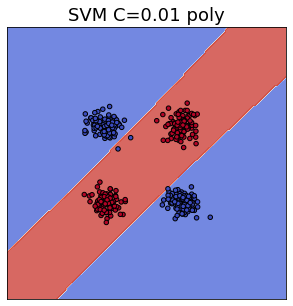

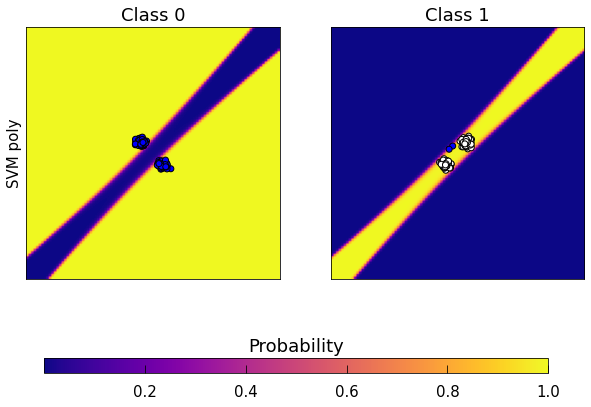

In [12]:
countour_SVM2(np.array(X_not_separable_df[['x1','x2']]),
              np.array(X_not_separable_df['class']),0.01,'poly',2,10,'ovr')

When you use a non-linear kernel in support vector machine modelling, you are actually making your data points behave as if they were embedded in some other manifolds (with infinite dimensions) and a non euclidian metric : making that embedding a non linear transformation of your initial space. **You embed/represent them on another manifold and then, on that manifold where hopefully things can be linearly separated, you proceed to your usual support vector machine.**

## A more basic and better embbeding for our problem: adding a dimension

In [13]:
X_not_separable_more_df=X_not_separable_df.copy()
X_not_separable_more_df['(x1-x2)**2']=(X_not_separable_df['x1']-X_not_separable_df['x2'])**2

In [27]:
### NOTE : if the code below gives an error, you can open the resulting figure resources/augmented_Xor.html
###        in your web browser 

import plotly.graph_objects as go
fig=go.Figure()

   
fig.add_trace(go.Scatter3d(x=X_not_separable_more_df['x1'], y=X_not_separable_more_df['x2'],
                           z=X_not_separable_more_df['(x1-x2)**2'],mode='markers',
                           marker=dict(size=[10]*len(X_not_separable_more_df),line=dict(width=0,color=None),
                                       color=[dico_color[X_not_separable_df['class'].loc[i]] for i in X_not_separable_df.index]),
                           connectgaps=False,hovertemplate = '<i><b>x<b></i>: %{x:.2f}<br>'+                           
                           '<i><b>y<b></i>: %{y:.2f}'+ '<br><b>z</b>: %{z:.2f}<br>'))
fig.update_layout(title='Dimension augmentation in Xor problem',
                  title_x=0.5,
                  xaxis_title='x1',
                  yaxis_title='x2')
plot(fig, filename = 'resources/augmented_Xor_test.html')
#fig.show()

'resources/augmented_Xor_test.html'

Just by adding another dimension to our space ($(x_1-x_2)^2$), the dataset becomes linearly separable. So the heart of the game is to find those good representations.

# Solving the Xor problem with pytorch and deep learning

## Recoding the basic logistic regression with pytorch

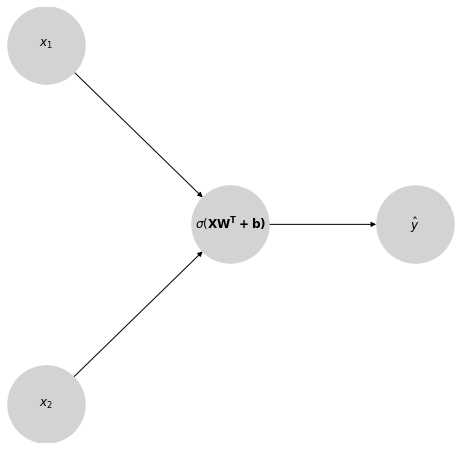

In [15]:
### NOTE : if the code below gives an error, you can open the resulting figure resources/basicLogistic_network.pdf
###        in your web browser 


class Homemade_Logisticreg(torch.nn.Module):
    def __init__(self):
        super(Homemade_Logisticreg, self).__init__()
        self.fc = nn.Linear(1,1)
        self.sigmoid = torch.nn.sigmoid() 
    def forward(self, x):
        output = self.fc(x)
        output = self.sigmoid(output) 
        return output
    


import os
os.environ["PATH"] += os.pathsep + '/home/seb/graphviz-2.38/release/bin/'#path where you installed it
import networkx as nx
#import dot2tex
from networkx.drawing.nx_agraph import to_agraph
dot=nx.DiGraph()
dot.add_node("A",pos=(0,0))
dot.add_node("x1",pos=(-0.5,0.5))
dot.add_node("x2",pos=(-0.5,-0.5))
dot.add_node("y",pos=(0.5,0))
dot.add_edge("x1", "A")
dot.add_edge("x2", "A")
dot.add_edge("A", "y")
pos=nx.get_node_attributes(dot,'pos')


plt.figure(figsize=(8,8))
nx.draw_networkx_labels(dot,pos,{"A":r"$\sigma(\bf{XW^{T}+b})$",
                                "x1":r"$x_1$","x2":r"$x_2$",
                                "y":r"$\hat{y}$"})
nx.draw(dot,pos,node_size=6000,node_color='lightgrey')


#plt.savefig( 'resources/basicLogistic_network.pdf')
plt.show()

## Shallow feed forward neural network : embedding then classifying

In [16]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            torch.nn.init.xavier_normal_(self.fc1.weight, 
                                         gain=torch.nn.init.calculate_gain('leaky_relu'))
            self.relu = torch.nn.LeakyReLU(0.1)
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

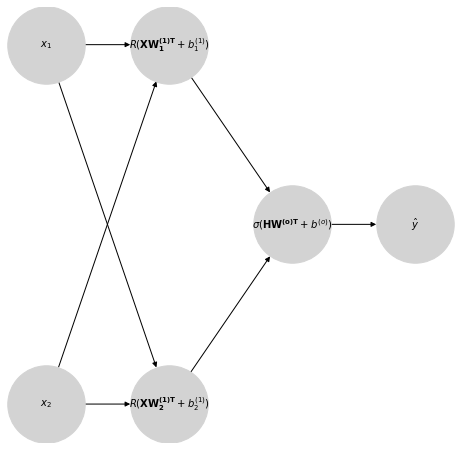

In [17]:
### NOTE : if the code below gives an error, you can open the resulting figure resources/shallowFeedForward_network.pdf
###        in your web browser 

dot=nx.DiGraph()
dot.add_node("A",pos=(0,0))
dot.add_node("x1",pos=(-1./2,1./3))
dot.add_node("x2",pos=(-1./2,-1./3))
dot.add_node("h1",pos=(-1./4,1./3))
dot.add_node("h2",pos=(-1./4,-1./3))
dot.add_node("y",pos=(1./4,0))
dot.add_edge("x1", "h1")
dot.add_edge("x2", "h1")
dot.add_edge("x1", "h2")
dot.add_edge("x2", "h2")
dot.add_edge("h1", "A")
dot.add_edge("h2", "A")
dot.add_edge("A", "y")
pos=nx.get_node_attributes(dot,'pos')


plt.figure(figsize=(8,8))

nx.draw_networkx_labels(dot,pos,{"A":r"$\sigma(\mathbf{HW^{(o)T}}+b^{(o)})$",
                                 "h1":r"$R(\mathbf{XW^{(1)T}_{1}}+b^{(1)}_{1})$",
                                 "h2":r"$R(\mathbf{XW^{(1)T}_{2}}+b^{(1)}_{2})$",
                                "x1":r"$x_1$","x2":r"$x_2$",
                                "y":r"$\hat{y}$"},font_size=10)

nx.draw(dot,pos,node_size=6000,node_color='lightgrey')

#plt.savefig( 'resources/shallowFeedForward_network.pdf')
plt.show()

You recognize the $\sigma(\bf{HW^{(o)T}+b^{(o)}})$ node which is just a logistic regression on your data points in the space $\mathcal{H}$ rather than $\mathcal{X}$. 

You embed your points in the $\mathcal{H}$ space by non lineraly transforming them . This transformation is linear up to the $\bf{R}$ function called **activation function**. Those activation functions can be of many sorts and we will spend some time looking at them later. Here I used the *Leaky Rectified Linear Uniform* function : 

$f(x) = \left \{ \begin{array}{rcl}
a x & \mbox{for} & x < 0\\ x & \mbox{for} & x \ge 0\end{array} \right. $ , where $a$ is 0.1 in our case


The game is now to find the good set of embedding weights ($\{\bf{W^{(1)}},\bf{b^{(1)}}\}$) so that the logistic regression can do its work by finding the good $\{\bf{W^{(o)}},\bf{b^{(o)}}\}$. 

> Note the upper script here is a $o$ that stands for output.

Just to write down things clearly once and for all, in our case and for only one data point:
- $\mathbf{W^{(1)}}$ is a matrix of shape (2,2)
- $\mathbf{X}$ is a matrix of shape (1,2)
- $\mathbf{W^{(1)}_1}$ is a matrix of shape (1,2)
- Thus $\mathbf{XW^{(1)T}_{1}}$ is a scalar and so is $b^{(1)}_{1}$
- $\mathbf{H}$ is column vector of shape (1,2)
- $\mathbf{W^{(o)}}$ is a matrix of shape (1,2)

You also have to realize that here, nodes are scalars, and the connections between nodes are the elements of the weights matrices being multiplied by your data points features, to give the scalar in the node.

You could also see this graph as a composition of functions : $f=\sigma \circ \mathcal{W^{(o)}}\circ R \circ \mathcal{W^{(1)}}$

## Training and visualizing our model

In [18]:
def training_overview(model,epochs,x_train,y_train,x_val,y_val):
    loss_fn = torch.nn.BCELoss() # loss function : binary cross entropy
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1,momentum = 0.9) # optimizer : stochastic gradient descent
    keep_loss=[]
    keep_loss_val=[]
    for epoch in range(epochs): # "epochs" correspond to optimization rounds for our model
        # Training mode
        model.train()
        
        optimizer.zero_grad()
        
        # Forward pass -> perform prediction from the data with the current state of the model
        output_train = model(x_train)
        
        # Compute Loss
        loss = loss_fn(output_train.squeeze(), y_train)
        keep_loss.append(loss.detach())
        
        
        # Backward pass -> this updates the weights according the result of the forward pass
        loss.backward()
        optimizer.step()
        
        # Evaluation mode
        model.eval()
        with torch.no_grad():
            output_val = model(x_val)
            loss_val = loss_fn(output_val.squeeze(), y_val)
            keep_loss_val.append(loss_val.detach())
        
        if epoch%100==0:
            print('Epoch {}: train loss: {} validation loss: {}'.format(epoch, loss.item(),loss_val.item()))
        
    plt.plot(np.arange(epochs),keep_loss,'r',label='training set')
    plt.plot(np.arange(epochs),keep_loss_val,'b',label='validation set')
    plt.xlabel('Epochs')
    plt.ylabel('Binary cross entropy loss')
    plt.legend(loc='best')
    plt.show()

In [19]:
from sklearn.model_selection import train_test_split

# creating a train, validation, and test set
X_train_val_df,X_test_df = train_test_split(X_not_separable_df,
                                                   random_state=0,stratify=X_not_separable_df['class'],test_size=0.1)

X_train_df, X_val_df = train_test_split(X_train_val_df,
                                                   random_state=0,stratify=X_train_val_df['class'],test_size=0.1)


#Pytorch needs torch tensor to work with
x_train=torch.FloatTensor(np.array(X_train_df[['x1','x2']]))
x_val=torch.FloatTensor(np.array(X_val_df[['x1','x2']]))
y_train=torch.FloatTensor(np.array(X_train_df['class']))
y_val=torch.FloatTensor(np.array(X_val_df['class']))

Epoch 0: train loss: 0.7703377604484558 validation loss: 0.7441846132278442
Epoch 100: train loss: 0.2302788645029068 validation loss: 0.22110025584697723
Epoch 200: train loss: 0.05506417900323868 validation loss: 0.054396823048591614
Epoch 300: train loss: 0.031704068183898926 validation loss: 0.031904976814985275
Epoch 400: train loss: 0.022956712171435356 validation loss: 0.023673705756664276
Epoch 500: train loss: 0.018377693369984627 validation loss: 0.019509676843881607
Epoch 600: train loss: 0.015538456849753857 validation loss: 0.016853658482432365
Epoch 700: train loss: 0.013588585890829563 validation loss: 0.015080170705914497
Epoch 800: train loss: 0.01215667650103569 validation loss: 0.013794816099107265
Epoch 900: train loss: 0.0110557796433568 validation loss: 0.012788131833076477


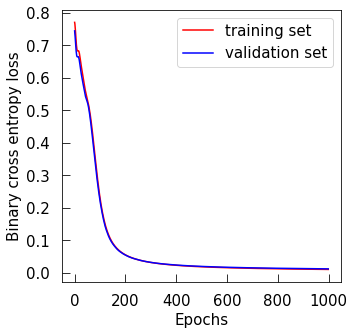

In [20]:
model=Feedforward(2, 2)
epochs=1000
training_overview(model,epochs,x_train,y_train,x_val,y_val)

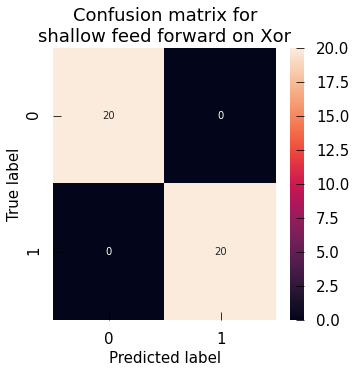

In [21]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
model.eval()


# performing prediction, note how this is the same as the forward pass
y_pred = model(torch.FloatTensor(np.array(X_test_df[['x1','x2']]))).detach().numpy()

y_pred=[0 if i<0.5 else 1 for i in y_pred]

confusion_mc_c = confusion_matrix(np.array(X_test_df['class']), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c,
                       index=[0,1],
                             columns=[0,1])

plt.figure(figsize=(5,5))
sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for\nshallow feed forward on Xor')
plt.show()
plt.close()

We can look at the output of the hidden layer to get a feeling for the space our data is projected upon before the logistic regression

In [22]:
# parameters of the hidden layer : 
W_hidden=model.fc1.weight
b_hidden=model.fc1.bias

In [23]:
print( W_hidden )
print( b_hidden )

Parameter containing:
tensor([[-5.1909,  5.1278],
        [-3.4922,  3.3887]], requires_grad=True)
Parameter containing:
tensor([0.0783, 2.9023], requires_grad=True)


So we have :

$W_{hidden} = \begin{bmatrix}
a & b \\
c & d 
\end{bmatrix} $

$b_{hidden} = \begin{bmatrix}
e & f  
\end{bmatrix} $

> I use letters because numbers vary from execution to execution

The projection in space $\mathcal{H}$ is basically the application of these coefficients in a linear relationship followed by the activation function: the leaky relu.

For instance, for a single point of coordinates ( $x_1$ , $x_2$ ) in $\mathcal{X}$, its coordinates ( $h_1$ , $h_2$ ) in $\mathcal{H}$ are:

$h_1 = leakyRELU( a * x_1 + b * x_2 + e)$

$h_2 = leakyRELU( c * x_1 + d * x_2 + f)$
    

In [24]:
# XW+b
linear_representation=np.array(X_not_separable_df[['x1','x2']])@W_hidden.detach().numpy().T + \
                        b_hidden.detach().numpy()

# leakyRelu(XW+b) 
ReLU_representation=[[i[p] if i[p]>0 else i[p]*0.1 for i in linear_representation]for p in range(2)]

In [25]:
# get a representation of the decision space in the original data space
xx,yy=make_meshgrid(np.array(X_not_separable_df['x1']),np.array(X_not_separable_df['x2']))
pred = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).detach().numpy()
Z=pred.reshape(xx.shape)

# get a representation of the decision space in the hidden layer space
# to do this we extract the last layer weight and apply them to all points on the grid
W_logreg=model.fc2.weight
b_logreg=model.fc2.bias
xx_rep,yy_rep=make_meshgrid(np.array(ReLU_representation[0]),np.array(ReLU_representation[1]))
pred_rep=sc.special.expit(np.array(np.c_[xx_rep.ravel(), yy_rep.ravel()])@W_logreg.detach().numpy().T + \
                          b_logreg.detach().numpy())

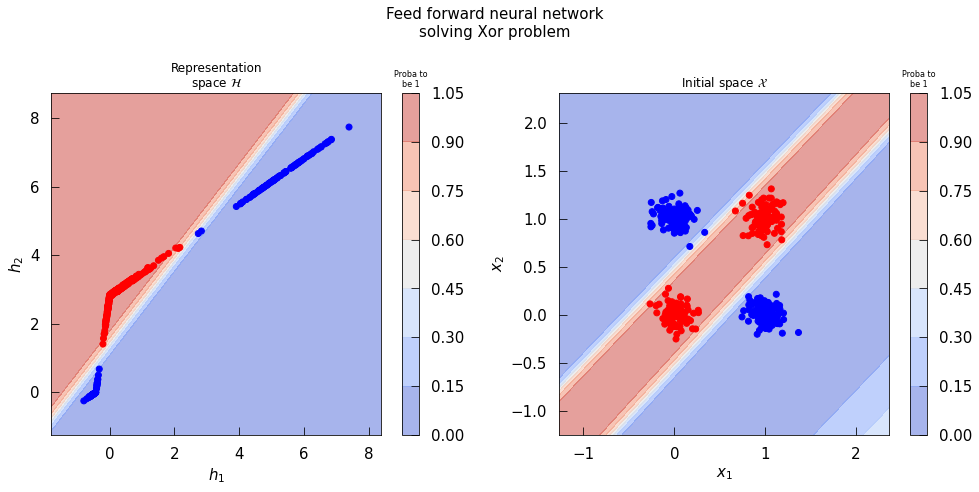

In [26]:
fig,ax=plt.subplots(1,2,figsize=(14,7))
fig.suptitle('Feed forward neural network\nsolving Xor problem', fontsize=15)
CS0=ax[0].contourf(xx_rep, yy_rep, pred_rep.reshape(yy_rep.shape), cmap=plt.cm.coolwarm, alpha=0.5)
ax[0].scatter(ReLU_representation[0],ReLU_representation[1],
           c=[dico_color[X_not_separable_df['class'].loc[i]] for i in X_not_separable_df.index])

cbar1=plt.colorbar(CS0,ax=ax[0])
cbar1.ax.set_title('Proba to\nbe 1',fontsize=8)
ax[0].set_xlabel(r'$h_1$')
ax[0].set_ylabel(r'$h_2$')
ax[0].set_title('Representation\nspace $\mathcal{H}$', fontsize=12)

CS1=ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
ax[1].scatter(X_not_separable_df['x1'],X_not_separable_df['x2'],
           c=[dico_color[X_not_separable_df['class'].loc[i]] for i in X_not_separable_df.index])
ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$x_2$')
ax[1].set_title('Initial space $\mathcal{X}$', fontsize=12)
cbar2=plt.colorbar(CS1,ax=ax[1])
cbar2.ax.set_title('Proba to\nbe 1',fontsize=8)
plt.tight_layout()
plt.show()

Thanks to the few nodes fully connected before the logistic regression, the neural net have found a representation of the data in the space $\mathcal{H}$ that is linearly separable (first plot). In $\mathcal{X}$ we can see the output of the non linear classifier.